
Training Label Distribution:
Class 0: 97 samples
Class 1: 4273 samples

Validation Label Distribution:
Class 0: 10 samples
Class 1: 633 samples


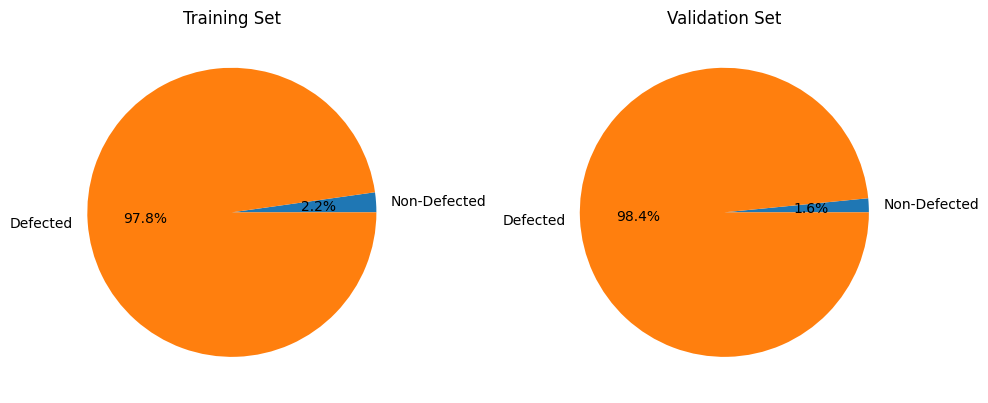

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
from matplotlib import pyplot as plt

# 路径设置
train_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset\images'
train_annotation_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset\annotations'

val_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset_2\images'
val_annotation_dir = r'E:\CDUT\English\7 Term\Project\model\archive\dataset_2\annotations'

additional_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\extra_2'
additional_val_image_dir = r'E:\CDUT\English\7 Term\Project\model\archive\extra_val_2'

IMG_HEIGHT = 512
IMG_WIDTH = 640
BATCH_SIZE = 16

# 修改后的数据管道构建函数
def create_dataset(image_paths, labels, shuffle=False):
    def parse_image(image_path, label):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=1)  # 加载为灰度图
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = tf.image.grayscale_to_rgb(image)  # 转为3通道
        image = image / 255.0  # 归一化
        return image, label
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset  # 注意这里不再进行批处理

# 获取文件路径和标签的函数
def get_image_paths_and_labels(image_dir, annotation_dir=None, is_additional=False):
    image_paths = []
    labels = []
    
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.png')):
            img_path = os.path.join(image_dir, filename)
            image_paths.append(img_path)
            
            if is_additional:
                # 额外数据默认为缺陷
                labels.append(1)
            else:
                # 从annotation加载标签
                annotation_path = os.path.join(
                    annotation_dir, 
                    filename.replace('.jpg', '.json').replace('.png', '.json')
                )
                with open(annotation_path, 'r') as f:
                    annotation = json.load(f)
                    instance_labels = [inst["defected_module"] for inst in annotation["instances"]]
                    # 如果任意模块有缺陷则标记为1
                    labels.append(1 if any(instance_labels) else 0)
    
    return image_paths, labels

# 获取所有数据路径和标签
train_image_paths, train_labels = get_image_paths_and_labels(train_image_dir, train_annotation_dir)
val_image_paths, val_labels = get_image_paths_and_labels(val_image_dir, val_annotation_dir)

# 获取额外数据路径
additional_image_paths, additional_labels = get_image_paths_and_labels(additional_image_dir, is_additional=True)
additional_val_paths, additional_val_labels = get_image_paths_and_labels(additional_val_image_dir, is_additional=True)

# 合并路径和标签
all_train_paths = train_image_paths + additional_image_paths
all_train_labels = train_labels + additional_labels

all_val_paths = val_image_paths + additional_val_paths
all_val_labels = val_labels + additional_val_labels

# 创建TensorFlow Dataset
train_dataset = create_dataset(all_train_paths, all_train_labels, BATCH_SIZE)
val_dataset = create_dataset(all_val_paths, all_val_labels, BATCH_SIZE)

# 标签分布分析
def print_label_distribution(labels, dataset_name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{dataset_name} Label Distribution:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples")

print_label_distribution(all_train_labels, "Training")
print_label_distribution(all_val_labels, "Validation")

# 可视化标签分布
def plot_label_distribution(train_labels, val_labels):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.pie(np.bincount(train_labels), labels=['Non-Defected', 'Defected'], autopct='%1.1f%%')
    plt.title("Training Set")
    
    plt.subplot(1, 2, 2)
    plt.pie(np.bincount(val_labels), labels=['Non-Defected', 'Defected'], autopct='%1.1f%%')
    plt.title("Validation Set")
    
    plt.tight_layout()
    plt.show()

plot_label_distribution(all_train_labels, all_val_labels)

# 模型构建部分保持不变...
# 后续的模型训练应使用train_dataset和val_dataset

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 14, 18, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 7,435,713
Non-trainable params: 14,629,472
_________________________________________________________________
Starting model training...
Epoch 1/10
274/274 [==============================] - 58s 183ms/step - loss

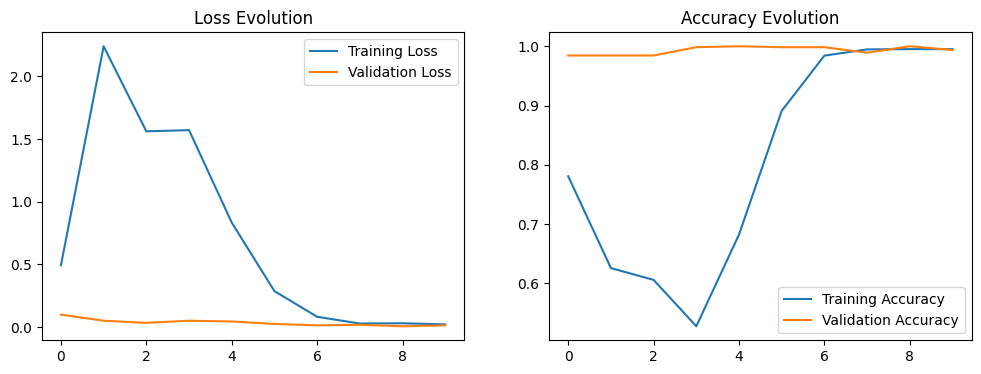

Sample predictions:
Predictions: [0.9860092  0.27278918 0.33666226 0.64801896 0.45157757 0.77247643
 0.7589767  0.40589714 0.4136034  0.3347267 ]
True Labels: [1 0 0 0 0 0 0 0 0 0]


In [3]:
# 修改后的模型训练和评估部分
# 移除以下不再需要的部分：
# - ImageDataGenerator
# - 所有对 *_images_combined 和 *_labels_combined 的引用

# 模型构建（保持不变）
def build_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# 创建并编译模型
model = build_model()
model.summary()

def create_augmented_dataset(image_paths, labels, batch_size=16):
    def augment(image, label):
        # 调整随机裁剪尺寸（处理三维图像）
        image = tf.image.random_crop(image, size=[
            int(IMG_HEIGHT*0.9), 
            int(IMG_WIDTH*0.9), 
            3  # 保持通道数不变
        ])
        image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
        return image, label
    
    # 创建基础数据集（未批处理）
    base_dataset = create_dataset(image_paths, labels)
    
    # 应用增强并添加批处理
    return base_dataset \
        .map(augment, num_parallel_calls=tf.data.AUTOTUNE) \
        .batch(batch_size) \
        .prefetch(tf.data.AUTOTUNE)

# 创建验证集管道（不需要增强）
def create_validation_dataset(image_paths, labels, batch_size=16):
    return create_dataset(image_paths, labels) \
        .batch(batch_size) \
        .prefetch(tf.data.AUTOTUNE)

# 创建最终数据集
augmented_train_dataset = create_augmented_dataset(all_train_paths, all_train_labels, BATCH_SIZE)
val_dataset = create_validation_dataset(all_val_paths, all_val_labels, BATCH_SIZE)

# 计算类别权重
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_train_labels),
    y=all_train_labels
)
class_weights = dict(enumerate(class_weights))

# 训练模型
print("Starting model training...")
history = model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=10,
    class_weight=class_weights
)

# 评估模型
val_loss, val_acc = model.evaluate(val_dataset)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

# 可视化训练过程
def plot_training(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss Evolution')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Evolution')
    
    plt.show()

plot_training(history)

# 修改5: 使用dataset进行预测（分批处理避免内存问题）
print("Sample predictions:")
for batch_images, batch_labels in val_dataset.take(1):  # 只取一个批次展示
    predictions = model.predict(batch_images)
    print(f"Predictions: {predictions[:10].flatten()}")
    print(f"True Labels: {batch_labels.numpy()[:10]}")

In [19]:
# 训练后保存优化后的模型
model.save('defect_detection_model.h5')

In [4]:
# 获取嵌套的 InceptionV3 模型
inception_v3 = model.get_layer("inception_v3")

# 打印 InceptionV3 内部所有层名称
for layer in inception_v3.layers:
    print(layer.name)

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

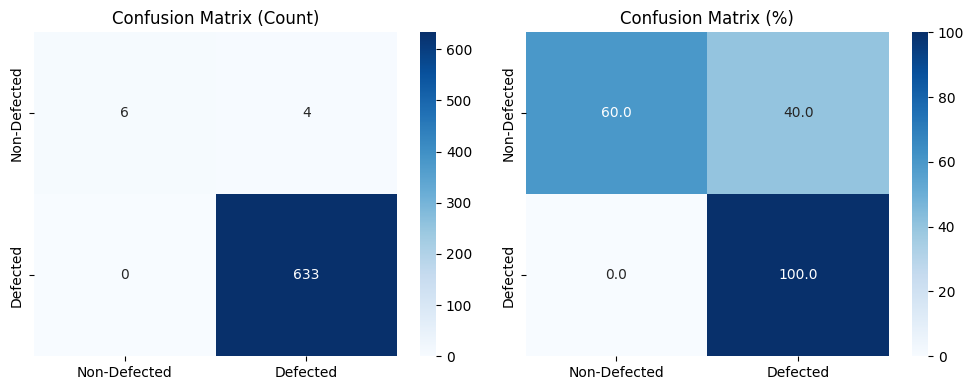


================ 综合评估 ================
- Accuracy:  0.9938
- Precision: 0.9937
- Recall:    1.0000
- F1 Score:  0.9969
- ROC AUC:   1.0000
- PR AUC:    1.0000


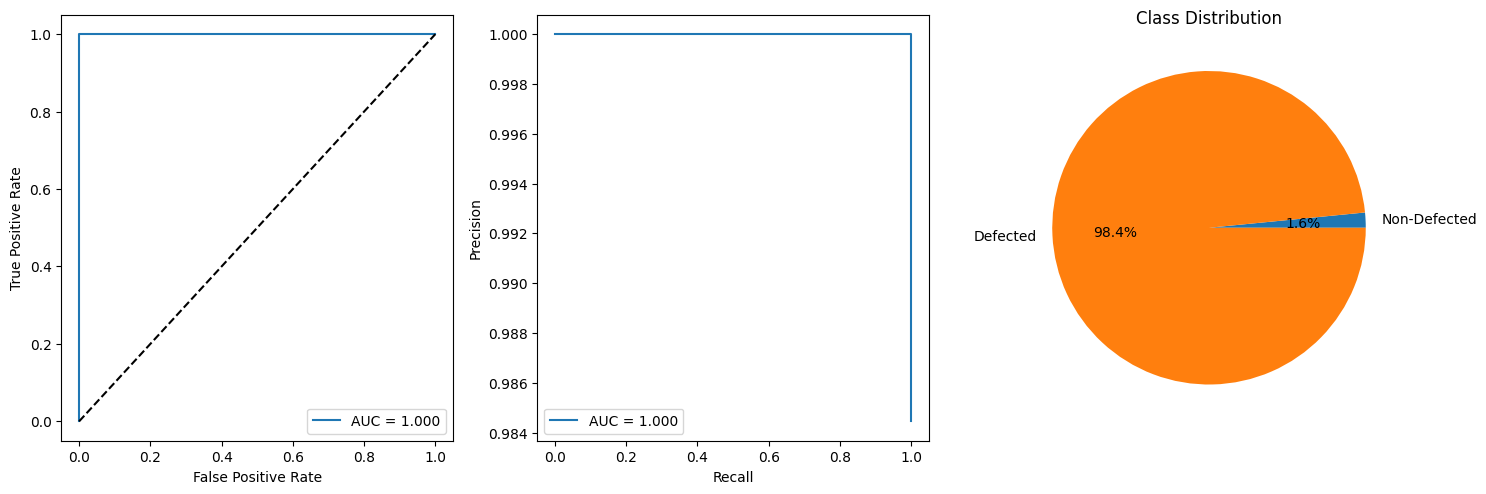


Classification Report:
              precision    recall  f1-score   support

Non-Defected       1.00      0.60      0.75        10
    Defected       0.99      1.00      1.00       633

    accuracy                           0.99       643
   macro avg       1.00      0.80      0.87       643
weighted avg       0.99      0.99      0.99       643



In [15]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score  # 确保包含所有必要指标
)
import seaborn as sns
import matplotlib.pyplot as plt

# 恢复数据集预测方式（兼容TensorFlow Dataset）
def get_predictions(model, dataset):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        y_true.extend(labels.numpy())
        y_pred.extend(model.predict(images).flatten())
    return np.array(y_true), np.array(y_pred)

# 获取预测结果（关键参数保持一致）
y_true, y_pred = get_predictions(model, val_dataset)  # 使用原始val_dataset参数
y_pred_binary = (y_pred > 0.5).astype(int)

# 恢复带百分比的混淆矩阵
cm = confusion_matrix(y_true, y_pred_binary)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
           xticklabels=["Non-Defected", "Defected"],
           yticklabels=["Non-Defected", "Defected"])
plt.title("Confusion Matrix (Count)")

plt.subplot(1,2,2)
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
           xticklabels=["Non-Defected", "Defected"],
           yticklabels=["Non-Defected", "Defected"])
plt.title("Confusion Matrix (%)")
plt.tight_layout()
plt.show()

# 恢复核心指标计算方式
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred_binary),
    "Precision": precision_score(y_true, y_pred_binary),
    "Recall": recall_score(y_true, y_pred_binary),
    "F1 Score": f1_score(y_true, y_pred_binary),
    "ROC AUC": roc_auc_score(y_true, y_pred),
    "PR AUC": auc(*precision_recall_curve(y_true, y_pred)[1::-1])  # 修正PR AUC计算
}

# 格式化的指标输出（保持原有风格）
print("\n================ 综合评估 ================")
for name, value in metrics.items():
    print(f"- {name + ':':<10} {value:.4f}")

# 恢复三图布局的可视化
plt.figure(figsize=(15,5))

# ROC曲线（保持原始参数）
plt.subplot(1,3,1)
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr, label=f'AUC = {metrics["ROC AUC"]:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# PR曲线（修正计算方式）
plt.subplot(1,3,2)
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision, label=f'AUC = {metrics["PR AUC"]:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# 类别分布（保持原始显示）
plt.subplot(1,3,3)
plt.pie([len(y_true)-sum(y_true), sum(y_true)],
        labels=['Non-Defected', 'Defected'],
        autopct='%1.1f%%')
plt.title('Class Distribution')

plt.tight_layout()
plt.show()

# 恢复分类报告（原始格式）
print("\nClassification Report:")
print(classification_report(y_true, y_pred_binary, 
                           target_names=["Non-Defected", "Defected"]))

Predictions shape: (1, 14, 18, 2048)
Selected class_idx: 2036
Image shape: (512, 640, 3)
Heatmap shape: (512, 640, 3)


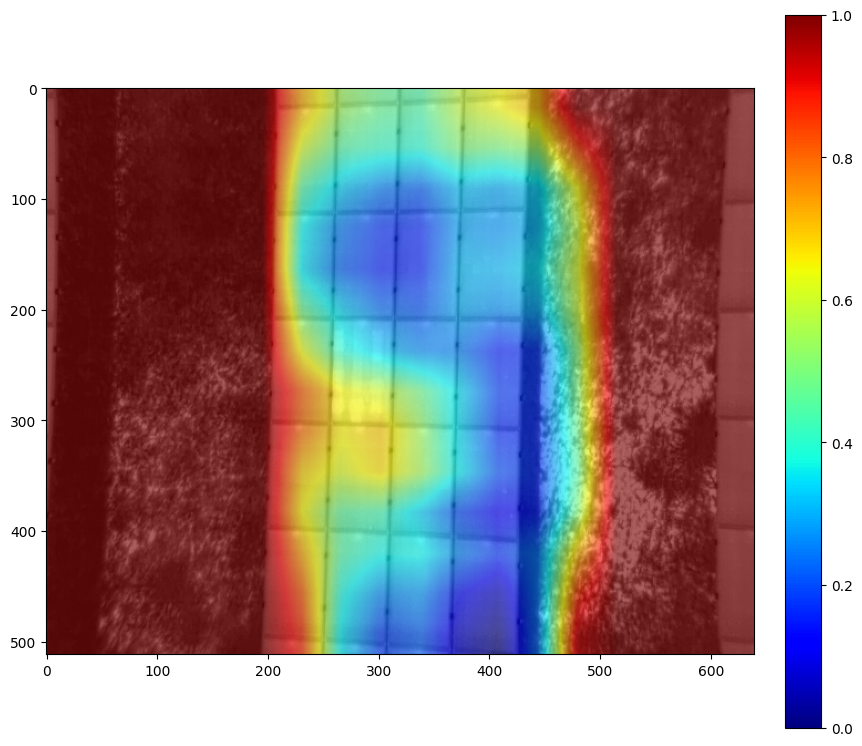

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
import cv2

def generate_grad_cam(model, img_array, target_layer_name, class_idx=None):
    # 获取目标层
    target_layer = model.get_layer(target_layer_name)
    grad_model = Model(inputs=model.input, outputs=[target_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # 检查 predictions 的形状
        print(f"Predictions shape: {predictions.shape}")

        # 如果 class_idx 为 None，选择最大预测值对应的索引
        if class_idx is None:
            class_idx = tf.argmax(predictions, axis=-1)  # 获取最大预测值的类别索引
            class_idx = tf.reduce_max(class_idx)  # 确保 class_idx 是标量
            print(f"Selected class_idx: {class_idx.numpy()}")

        # 确保 class_idx 是标量
        class_idx = tf.cast(class_idx, tf.int32)

        # 计算 loss
        loss = tf.reduce_mean(predictions[..., class_idx])  # 确保 predictions 是 [batch_size, height, width, num_classes] 格式

    # 计算梯度
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 生成热力图
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_grad_cam(img_path, heatmap, output_size=(640, 512), alpha=0.6):
    img = load_img(img_path)
    img = img.resize(output_size)
    img = img_to_array(img).astype("uint8")
    
    # 确保热力图的大小和通道数与输入图像匹配
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (output_size[0], output_size[1]))  # 调整热力图大小
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # 确保输入图像和热力图的通道数匹配
    if img.shape[-1] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # 检查图像和热力图的大小和通道数
    print(f"Image shape: {img.shape}")
    print(f"Heatmap shape: {heatmap.shape}")
    
    # 调整图像和热力图的大小和通道数
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    if img.shape[-1] != heatmap.shape[-1]:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.colorbar(plt.cm.ScalarMappable(cmap='jet'), orientation='vertical', fraction=0.046, pad=0.04)
    plt.show()
    
# 预处理输入图像
def preprocess_image(img_path, target_size=(512, 640)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


# 模型加载
model = tf.keras.models.load_model('./defect_detection_model.h5')  # 替换为你的模型路径

# 提取嵌套的 InceptionV3 模型
inception_model = model.get_layer("inception_v3")

# 目标层名称设置为 InceptionV3 的最后一个卷积层
target_layer_name = "mixed10"

# 测试图像路径
img_path = r'E:\CDUT\English\7 Term\Project\model\archive\dataset\images\041R.jpg'  # 替换为你的测试图像路径
img_array = preprocess_image(img_path, target_size=(512, 640))

# 生成 Grad-CAM
heatmap = generate_grad_cam(inception_model, img_array, target_layer_name)

# 显示结果
display_grad_cam(img_path, heatmap)


In [ ]:
from numba import cuda

cuda.select_device(0)
cuda.close()